In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Step - 1 Load Data

In [2]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [4]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/test/pizza/398345.jpg
Image class: pizza
Image height: 344
Image width: 512


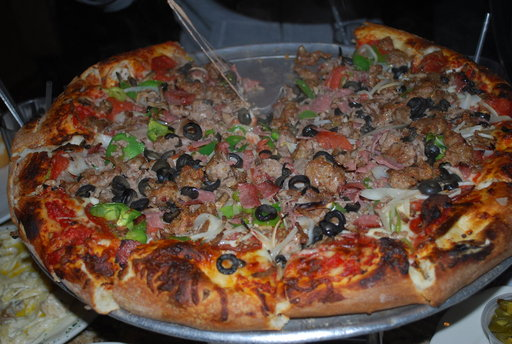

In [6]:
import random
from PIL import Image

# Set seed
random.seed(19)

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with matplotlib.pyplot.imshow(), except we have to convert the image to a NumPy array first.

In [7]:
# Write transform for image
fdata = transforms.Compose([
    # Resize the images acording to input of cnn
    transforms.Resize(size=(32, 32)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

In [8]:
def plot_transformed_images(image_paths, transform, n=3, seed=19):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform=fdata,
                        n=3)

NameError: name 'plt' is not defined

**Creating our Datset**

In [9]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=fdata, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=fdata)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [10]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [11]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

In [12]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1020, 0.0980, 0.0941,  ..., 0.1255, 0.1255, 0.1255],
         [0.1020, 0.0941, 0.0824,  ..., 0.1294, 0.1333, 0.1333],
         [0.0902, 0.0745, 0.0667,  ..., 0.1176, 0.1529, 0.2667],
         ...,
         [0.3608, 0.3961, 0.4157,  ..., 0.1843, 0.1725, 0.1686],
         [0.1255, 0.1412, 0.1529,  ..., 0.1804, 0.1725, 0.1686],
         [0.0941, 0.1059, 0.1176,  ..., 0.1804, 0.1686, 0.1686]],

        [[0.0706, 0.0745, 0.0706,  ..., 0.0588, 0.0627, 0.0627],
         [0.0745, 0.0745, 0.0667,  ..., 0.0667, 0.0706, 0.0706],
         [0.0745, 0.0627, 0.0510,  ..., 0.0627, 0.0706, 0.0902],
         ...,
         [0.3373, 0.3804, 0.4118,  ..., 0.2745, 0.2588, 0.2471],
         [0.1373, 0.1569, 0.1804,  ..., 0.2745, 0.2588, 0.2392],
         [0.1098, 0.1255, 0.1490,  ..., 0.2706, 0.2510, 0.2353]],

        [[0.0902, 0.0902, 0.0863,  ..., 0.0118, 0.0157, 0.0196],
         [0.0902, 0.0863, 0.0745,  ..., 0.0157, 0.0157, 0.0196],
         [0.0784, 0.0627, 0.0353,  ..., 0.03

**Right now our image dimensions are in the format CHW (color channels, height, width) but matplotlib prefers HWC (height, width, color channels).**

In [13]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img.permute(1, 2, 0))
plt.axis("off")
plt.title(class_names[label], fontsize=14);

Original shape: torch.Size([3, 32, 32]) -> [color_channels, height, width]
Image permute shape: torch.Size([32, 32, 3]) -> [height, width, color_channels]


NameError: name 'plt' is not defined

In [14]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b3361af6e30>,
 <torch.utils.data.dataloader.DataLoader at 0x7b3361af6a40>)

In [15]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 32, 32]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


In [16]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 & 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [17]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transforms,
    n=3,
    seed=None
)

NameError: name 'plt' is not defined

In [18]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

In [19]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7b3361af7460>,
 <torch.utils.data.dataloader.DataLoader at 0x7b3361af5cf0>)

# Step - 2 Model Architecture

In [23]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,6,5,1)
    self.conv2 = nn.Conv2d(6,16,5,1)
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,3)

  def forward(self,x):
    x = F.tanh(self.conv1(x))
    x = F.avg_pool2d(x,2,2)
    x = F.tanh(self.conv2(x))
    x = F.avg_pool2d(x,2,2)

    #flatten
    x = x.view(-1,5*5*16)

    #dense layers
    x = F.tanh(self.fc1(x))
    x = F.tanh(self.fc2(x))
    x = self.fc3(x)

    return F.softmax(x,dim=1)

In [24]:
torch.manual_seed(19)
model = LeNet().to(device)
model

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [25]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader_simple))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))

# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 3, 32, 32])

Output logits:
tensor([[0.3398, 0.3178, 0.3424]], device='cuda:0')

Output prediction probabilities:
tensor([[0.3355, 0.3282, 0.3363]], device='cuda:0')

Output prediction label:
tensor([2], device='cuda:0')

Actual label:
1


**Summary of our model**

In [28]:
!pip install torchinfo
import torchinfo
from torchinfo import summary

In [30]:
summary(model, input_size=[1, 3, 32, 32]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 3]                    --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─Conv2d: 1-2                            [1, 16, 10, 10]           2,416
├─Linear: 1-3                            [1, 120]                  48,120
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 3]                    255
Total params: 61,411
Trainable params: 61,411
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.31

# Step - 3 Training and Testing

In [32]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [33]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [34]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 20):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [50]:
# Set random seeds
torch.manual_seed(19)
torch.cuda.manual_seed(19)

# Set number of epochs
NUM_EPOCHS = 50

# Recreate an instance of LeNet
model_0 = LeNet().to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0899 | train_acc: 0.4414 | test_loss: 1.0958 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.1034 | train_acc: 0.3047 | test_loss: 1.1210 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0769 | train_acc: 0.4414 | test_loss: 1.1153 | test_acc: 0.3438
Epoch: 4 | train_loss: 1.0872 | train_acc: 0.3164 | test_loss: 1.0985 | test_acc: 0.3542
Epoch: 5 | train_loss: 1.0428 | train_acc: 0.5352 | test_loss: 1.0884 | test_acc: 0.3125
Epoch: 6 | train_loss: 1.0007 | train_acc: 0.5781 | test_loss: 1.0701 | test_acc: 0.3532
Epoch: 7 | train_loss: 0.9541 | train_acc: 0.6133 | test_loss: 1.0992 | test_acc: 0.3220
Epoch: 8 | train_loss: 0.9902 | train_acc: 0.4883 | test_loss: 1.0962 | test_acc: 0.3627
Epoch: 9 | train_loss: 0.9074 | train_acc: 0.6211 | test_loss: 1.0373 | test_acc: 0.5047
Epoch: 10 | train_loss: 0.9039 | train_acc: 0.6641 | test_loss: 1.0969 | test_acc: 0.3523
Epoch: 11 | train_loss: 0.9008 | train_acc: 0.6562 | test_loss: 1.1014 | test_acc: 0.3939
Epoch: 12 | train_l

In [51]:
from typing import Dict, List

In [52]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

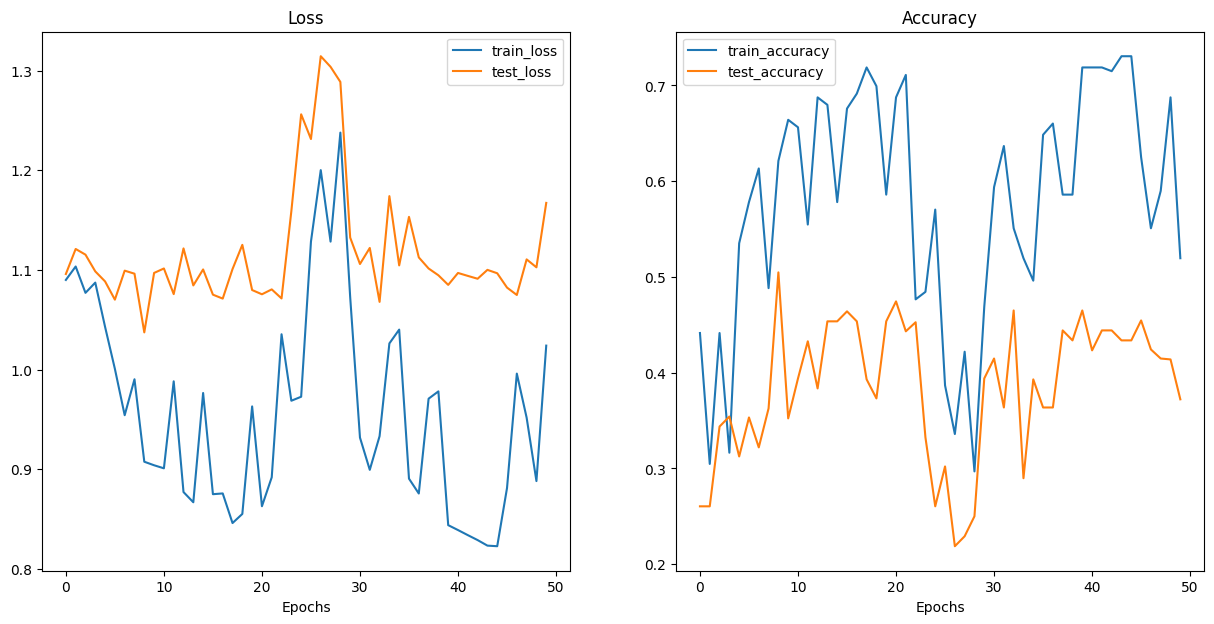

In [53]:
plot_loss_curves(model_0_results)

In [54]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

In [55]:
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [56]:
# Turn Datasets into DataLoader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b3333f57ca0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b3361af6a40>)

In [57]:
# Create model_1 and send it to the target device
torch.manual_seed(19)
model_1 = LeNet().to(device)
model_1

LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [58]:
# Set random seeds
torch.manual_seed(19)
torch.cuda.manual_seed(19)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0902 | train_acc: 0.4180 | test_loss: 1.1109 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0852 | train_acc: 0.4258 | test_loss: 1.1614 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0765 | train_acc: 0.4258 | test_loss: 1.1420 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1190 | train_acc: 0.3047 | test_loss: 1.1258 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0946 | train_acc: 0.3047 | test_loss: 1.0894 | test_acc: 0.2812
Epoch: 6 | train_loss: 1.0906 | train_acc: 0.3828 | test_loss: 1.0799 | test_acc: 0.4451
Epoch: 7 | train_loss: 1.0786 | train_acc: 0.3594 | test_loss: 1.0558 | test_acc: 0.3428
Epoch: 8 | train_loss: 1.0720 | train_acc: 0.4648 | test_loss: 1.0506 | test_acc: 0.5758
Epoch: 9 | train_loss: 1.0643 | train_acc: 0.3984 | test_loss: 1.0979 | test_acc: 0.3106
Epoch: 10 | train_loss: 1.0534 | train_acc: 0.3438 | test_loss: 1.0267 | test_acc: 0.4943
Epoch: 11 | train_loss: 1.0303 | train_acc: 0.4336 | test_loss: 1.0600 | test_acc: 0.3438
Epoch: 12 | train_l

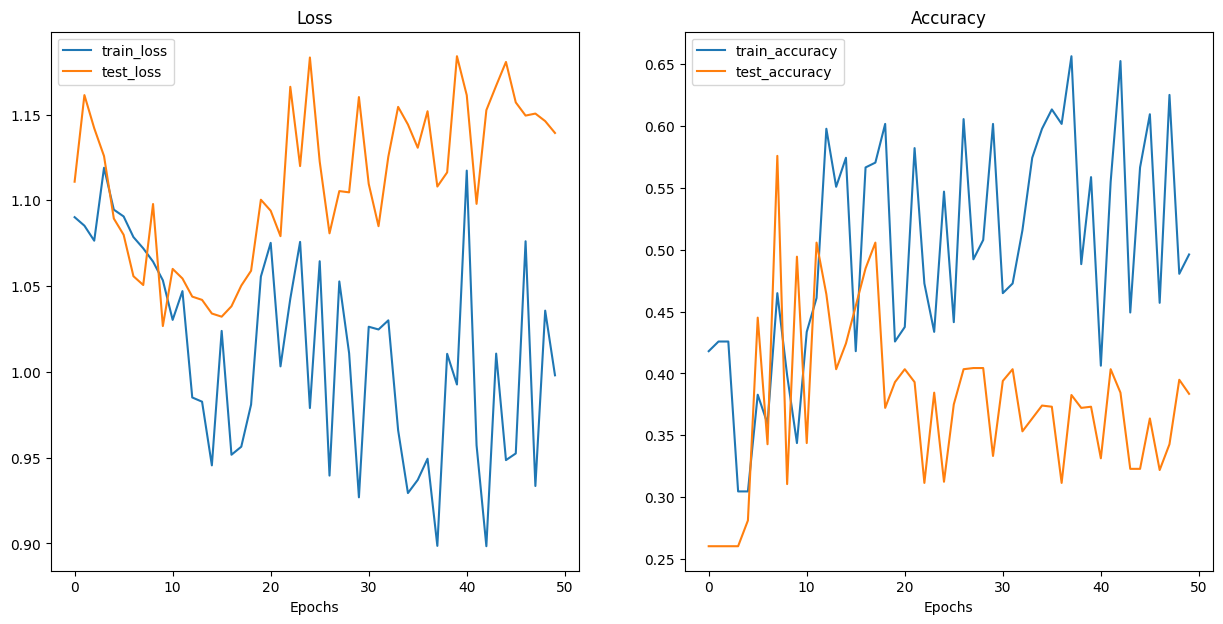

In [59]:
plot_loss_curves(model_1_results)